In [1]:
import pandas as pd
import datasets
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments, PretrainedConfig
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import sklearn.metrics as metric
from tqdm import tqdm
import wandb
import os


In [2]:
path  = '/home/csgrad/smaranas/STDA/'

In [3]:
# load model and tokenizer and define length of the text sequence
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [4]:
train_data = datasets.load_dataset('csv', data_files='p2_train.csv', split='train')
test_data = datasets.load_dataset('csv', data_files='p2_test.csv', split='train')


Using custom data configuration default-7c8f520c6348ed4a
Reusing dataset csv (/home/csgrad/smaranas/.cache/huggingface/datasets/csv/default-7c8f520c6348ed4a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
Using custom data configuration default-62258532d28b83d4
Reusing dataset csv (/home/csgrad/smaranas/.cache/huggingface/datasets/csv/default-62258532d28b83d4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


In [5]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
  return tokenizer(batched_text['text'], padding = True, truncation=True)


train_data = train_data.map(tokenization, batched = True, batch_size = len(train_data))
test_data = test_data.map(tokenization, batched = True, batch_size = len(test_data))


Loading cached processed dataset at /home/csgrad/smaranas/.cache/huggingface/datasets/csv/default-7c8f520c6348ed4a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-5926909e6b8bf367.arrow
Loading cached processed dataset at /home/csgrad/smaranas/.cache/huggingface/datasets/csv/default-62258532d28b83d4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-c8222f0855df19d8.arrow


In [6]:
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


In [7]:
# define accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    # fpr, tpr, threshold = metric.roc_curve(labels, preds, pos_label=1)
    # # calibration_loss = metric.brier_score_loss(labels, )

    # fnr = 1 - tpr
    # eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    # EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    # EER1 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
    # if EER == EER1:
    #   print('EER sanity check passed')
    #   print('fpr : ', fpr)
    #   print('tpr : ', tpr)
    #   print('threshold : ', threshold)
    #   print('EER : ', EER)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        # 'fpr': fpr, 
        # 'tpr': tpr, 
        # 'threshold': threshold,
        # 'EER': EER,
        
    }

In [15]:
#  define the training arguments
training_args = TrainingArguments(
    output_dir = path,
    num_train_epochs=1,
    per_device_train_batch_size = 3,#4
    gradient_accumulation_steps = 16,    
    per_device_eval_batch_size= 8,
    evaluation_strategy = "epoch",
    disable_tqdm = False, 
    save_strategy = "epoch",
    load_best_model_at_end=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps = 8,
    # fp16 = True,
    logging_dir=path+'/logs',
    dataloader_num_workers = 0,
    run_name = 'roberta-classification_titan'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [16]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1705
  Num Epochs = 30
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 16
  Total optimization steps = 240
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: psmaran

/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.696400,0.689909,0.544601,0.352584,0.272300,0.500000
1,0.774800,0.689351,0.697183,0.664479,0.742888,0.674702
2,0.769300,0.687211,0.464789,0.406018,0.493443,0.496801
3,0.759600,0.671107,0.507042,0.464555,0.562961,0.536438
4,0.721900,0.621342,0.629108,0.625109,0.655942,0.643441
5,0.656700,0.567341,0.753521,0.731891,0.801244,0.734025
6,0.603600,0.539357,0.755869,0.734827,0.802804,0.736602
7,0.585100,0.513712,0.755869,0.734827,0.802804,0.736602
8,0.557800,0.458360,0.748826,0.719852,0.823358,0.725915
9,0.488600,0.416302,0.755869,0.730799,0.819354,0.734492


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-8
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-8/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-8/pytorch_model.bin
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were s

***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-80
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-80/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-80/pytorch_model.bin
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/ch

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-160
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-160/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-160/pytorch_model.bin
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forw

  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-232
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-232/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-232/pytorch_model.bin
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-240
Configuration s

TrainOutput(global_step=240, training_loss=0.33168157742669185, metrics={'train_runtime': 1867.2533, 'train_samples_per_second': 27.393, 'train_steps_per_second': 0.129, 'total_flos': 1.341366471330816e+16, 'train_loss': 0.33168157742669185, 'epoch': 29.9})

In [11]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.2859164774417877,
 'eval_accuracy': 0.9272300469483568,
 'eval_f1': 0.9267907332568313,
 'eval_precision': 0.9261395081132535,
 'eval_recall': 0.9277017419125488,
 'eval_runtime': 2.7712,
 'eval_samples_per_second': 153.726,
 'eval_steps_per_second': 5.052,
 'epoch': 29.9}

In [12]:
!nvidia-smi -L


GPU 0: GeForce RTX 2080 Ti (UUID: GPU-7f930eb1-7889-010a-7bdc-0af4745b23ee)
GPU 1: GeForce RTX 2080 Ti (UUID: GPU-fd3ac735-6b86-cb59-2eda-73128446cdc8)
GPU 2: GeForce RTX 2080 Ti (UUID: GPU-bfee90cf-6b95-364a-9d28-8788cb1154aa)
GPU 3: GeForce RTX 2080 Ti (UUID: GPU-bff12621-4900-b812-5ba6-c920c1989d0f)


In [17]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1705
  Num Epochs = 1
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 16
  Total optimization steps = 8
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.068700,0.286982,0.917840,0.916995,0.918123,0.916126


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-8
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-8/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-8/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /home/csgrad/smaranas/STDA/checkpoint-8 (score: 0.2869824767112732).


TrainOutput(global_step=8, training_loss=0.06871471554040909, metrics={'train_runtime': 57.8432, 'train_samples_per_second': 29.476, 'train_steps_per_second': 0.138, 'total_flos': 404138581032960.0, 'train_loss': 0.06871471554040909, 'epoch': 0.9})

In [18]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.2869824767112732,
 'eval_accuracy': 0.9178403755868545,
 'eval_f1': 0.9169946611589572,
 'eval_precision': 0.9181233674904561,
 'eval_recall': 0.9161260220405261,
 'eval_runtime': 2.7095,
 'eval_samples_per_second': 157.222,
 'eval_steps_per_second': 5.167,
 'epoch': 0.9}

In [19]:
for i in range(30):
    trainer.train()
    trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1705
  Num Epochs = 1
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 16
  Total optimization steps = 8
/home/csgrad/smaranas/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.038500,0.336919,0.922535,0.922123,0.921360,0.923391


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-8
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-8/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-8/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /home/csgrad/smaranas/STDA/checkpoint-8 (score: 0.33691927790641785).
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassificati

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1705
  Num Epochs = 1
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 16
  Total optimization steps = 8


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.031000,0.339772,0.922535,0.921581,0.923999,0.920014
0,0.031000,0.339772,0.922535,0.921581,0.923999,0.920014


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8
Saving model checkpoint to /home/csgrad/smaranas/STDA/checkpoint-8
Configuration saved in /home/csgrad/smaranas/STDA/checkpoint-8/config.json
Model weights saved in /home/csgrad/smaranas/STDA/checkpoint-8/pytorch_model.bin


RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 478743040 vs 478742928

In [20]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, Unnamed: 0. If text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 426
  Batch size = 8


{'eval_loss': 0.33977213501930237,
 'eval_accuracy': 0.9225352112676056,
 'eval_f1': 0.9215806590169968,
 'eval_precision': 0.9239991028372772,
 'eval_recall': 0.9200142196942767}

In [2]:
training_loss = [0.696400,
0.774800,
0.769300,
0.759600,
0.721900,
0.656700,
0.603600,
0.585100,
0.557800,
0.488600,
0.437700,
0.346100,
0.322400,
0.289500,
0.253200,
0.220800,
0.194800,
0.197900,
0.132500,
0.121800,
0.117700,
0.088200,
0.107700,
0.076800,
0.072400,
0.102800,
0.062300,
0.031100,
0.067500,
0.093400,]

In [3]:
validation_loss = [0.689909,
0.689351,
0.687211,
0.671107,
0.621342,
0.567341,
0.539357,
0.513712,
0.458360,
0.416302,
0.398005,
0.425519,
0.422737,
0.375140,
0.360107,
0.347480,
0.329412,
0.317975,
0.341938,
0.389673,
0.288155,
0.322406,
0.340263,
0.285916,
0.486961,
0.348469,
0.322007,
0.508089,
0.348094,
0.568766,]

In [4]:
accuracy = [0.544601,
0.697183,
0.464789,
0.507042,
0.629108,
0.753521,
0.755869,
0.755869,
0.748826,
0.755869,
0.816901,
0.833333,
0.823944,
0.861502,
0.880282,
0.884977,
0.894366,
0.922535,
0.908451,
0.908451,
0.924883,
0.908451,
0.915493,
0.927230,
0.875587,
0.920188,
0.929577,
0.882629,
0.920188,
0.894366,]

In [5]:
f1 = [0.352584,
0.664479,
0.406018,
0.464555,
0.625109,
0.731891,
0.734827,
0.734827,
0.719852,
0.730799,
0.814132,
0.833259,
0.821774,
0.860450,
0.880202,
0.883168,
0.893065,
0.922123,
0.907755,
0.908268,
0.924145,
0.906782,
0.915126,
0.926791,
0.870920,
0.919327,
0.929226,
0.879178,
0.919073,
0.894319,]

In [6]:
precision = [0.272300,
0.742888,
0.493443,
0.562961,
0.655942,
0.801244,
0.802804,
0.802804,
0.823358,
0.819354,
0.817615,
0.836168,
0.823674,
0.860306,
0.882496,
0.887737,
0.895335,
0.921360,
0.907592,
0.908451,
0.925022,
0.913660,
0.914348,
0.926140,
0.896171,
0.920749,
0.928417,
0.896053,
0.922649,
0.897336,]

In [7]:
recall = [0.500000,
0.674702,
0.496801,
0.536438,
0.643441,
0.734025,
0.736602,
0.736602,
0.725915,
0.734492,
0.812478,
0.838118,
0.820632,
0.860603,
0.885020,
0.880888,
0.891619,
0.923391,
0.907927,
0.911727,
0.923436,
0.903706,
0.916926,
0.927702,
0.865513,
0.918281,
0.930701,
0.874511,
0.917015,
0.899640,]

In [8]:
epoch = range(1,31)

In [9]:
import matplotlib.pyplot as plt

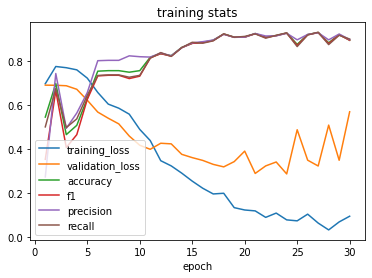

In [14]:
plt.plot(epoch, training_loss, label='training_loss')
plt.plot(epoch, validation_loss, label='validation_loss')
plt.plot(epoch, accuracy, label='accuracy')
plt.plot(epoch, f1, label='f1')
plt.plot(epoch, precision, label='precision')
plt.plot(epoch, recall, label='recall')

plt.xlabel('epoch')
plt.legend()
plt.title('training stats')
plt.savefig('training_stats.png')

In [ ]:
# plt.plot(X, y, color='r', label='sin')
# plt.plot(X, z, color='g', label='cos')
  
# # Naming the x-axis, y-axis and the whole graph
# plt.xlabel("Angle")
# plt.ylabel("Magnitude")
# plt.title("Sine and Cosine functions")